In [11]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [14]:
# path config
data_path = os.path.join(os.getcwd(), 'ml-latest-small')
movies_filename = 'movies.csv'
ratings_filename = 'ratings.csv'

1. Load Data

In [16]:
df_movies = pd.read_csv(
    os.path.join(data_path, movies_filename),
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    os.path.join(data_path, ratings_filename),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [19]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int32 
 1   title    9742 non-null   object
dtypes: int32(1), object(1)
memory usage: 76.2+ KB


In [20]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int32  
 1   movieId  100836 non-null  int32  
 2   rating   100836 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 1.2 MB


In [21]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [22]:
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [26]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('{} usuarios exclusivos e {} filmes exclusivos encontrados'.format(num_users, num_items))

610 usuarios exclusivos e 9724 filmes exclusivos encontrados


## 2. Analise exploratoria dos dados
    - Traçando a contagem de cada avaliçao
    - Traçando a frequencia da avaliaçao de cada filme

a. traçando a contagem de cada avaliaçao

O primeiro passo é ter as contagens de cada avaliaçao a partir dos dados de avaliaçao.

In [27]:
# obtendo contagem
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [29]:
# Há muito mais contagens na classificação de zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# Acrescentar contagens de classificação zero a df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


A contagem para pontuação de classificação zero é muito grande para comparar com outras. Então, vamos pegar a transformação de log para valores de contagem e, então, podemos plotá-los para comparar

In [30]:
# Adicionando contagem de log
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,5830804,15.578665
0.5,1370,7.222566
1.0,2811,7.941296
1.5,1791,7.490529
2.0,7551,8.929435
2.5,5550,8.621553
3.0,20047,9.905835
3.5,13136,9.483112
4.0,26818,10.196829
4.5,8551,9.053804


Text(0, 0.5, 'Número de avaliações')

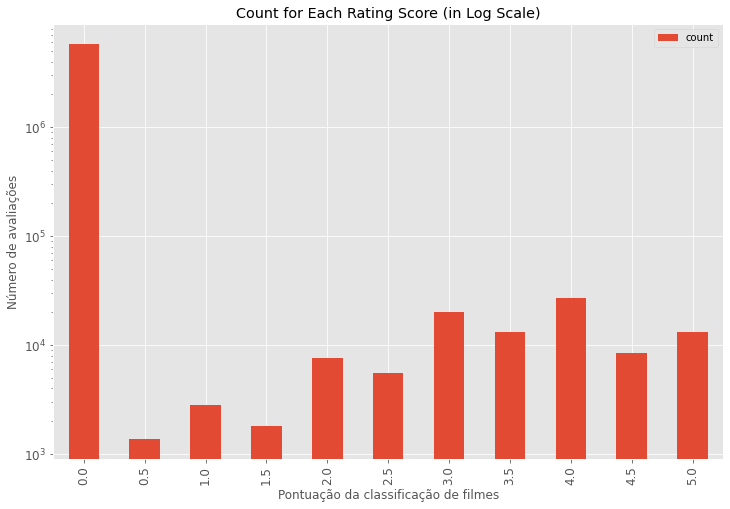

In [34]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("Pontuação da classificação de filmes")
ax.set_ylabel("Número de avaliações")


<p>É interessante que há mais pessoas classificando a pontuaçao entre 3 e 4 do que outras pontuaçoes</p>

b. traçando a frequencia de classificaçao de todos os filmes

In [35]:
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
